# Preprocess:

* It handles Turkish-specific case conversions ('İ' to 'i') before applying a general lowercase transformation.

* A large, custom dictionary is used to expand a wide range of common Turkish address abbreviations to their canonical full forms (mah., mh., mhal. are all converted to mahallesi). This step standardizes the vocabulary significantly.

* Regular expressions are used to standardize address structures. This includes separating conjoined numbers and letters (90A becomes 90 A), and normalizing numerical signifiers (no:10, numara 10 all become no 10). Punctuation is removed, but slashes between digits (like 116/2) are preserved to maintain context.

* A critical decision was made to treat floor and unit numbers as noise and remove them completely (kat:1, daire:2 are deleted). This is based on the observation that different numbers often be found within the same address label. Additionally, common stop words and very long, likely erroneous words are removed to de-noise the input.

* The example below shows some addresses that all have the label 1695. As you can see the door and floor numbers and even street numbers are different. We decided to delete the floor and door numbers for the noise reduction and preserve the street and building numbers, thinking the model might learn some context from them.

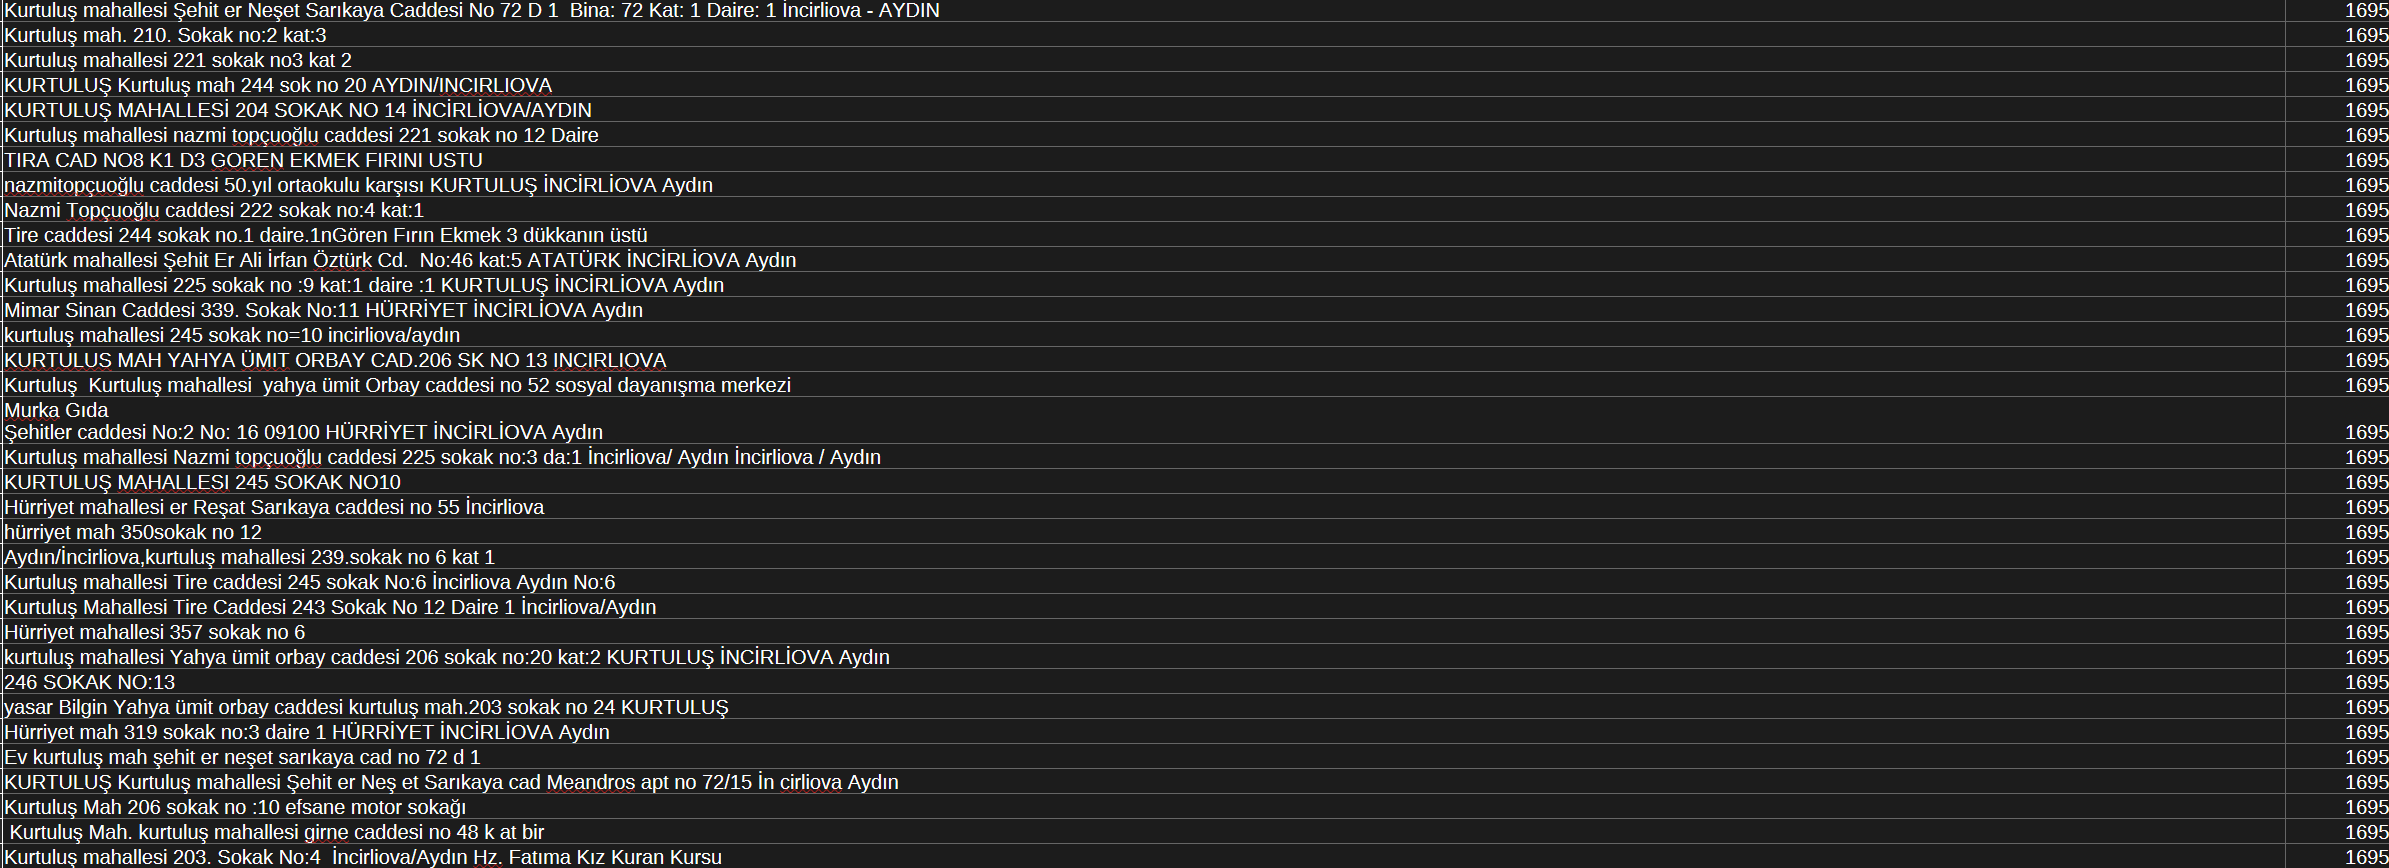

* First 20 addresses before preprocess:

  * Akarca Mah. Adnan Menderes Cad. 864.Sok. No:15 D.1 K.2 .
  * Cumhuriye Mah. Hükümet Cad. Sivriler İşhanı No:3 Fethiye/Muğla Foto Kandiye Muğla / Fethiye
  * İsmet inönü mahallesi 2001 sokak no:2 Çeşme belediyesi Çeşme
  * Gazeteci Hasan Tahsin Caddesi, No:10/3,  Gizem Apartman 
  * Bitez mahallesi Adnan Menderes caddesi gündonumu mevkii 1410.sokak no 90A Doria hotel
  * Dedebaşı mahallesi 6100 sokak no 10 Kat 7 daire 25 
  * Dikili Güzelbelde Sitesi Müsellim Altı No:51 Kabakum Dikili / İzmir  KABAKUM DİKİLİ İzmir
  * Yeni sanayi mahallesi 515 sokak no 53 c3 blok emek aliminyum
  * Pazaryeri mah. 417. sk. No:6/4 Fethiye/MUĞLA
  * Gümüşlük mah. 5215 sok. D blok dış kapı no: 1 daire:2 Bodrum/muğla GÜMÜŞLÜK BODRUM Muğla
  * Şemikler Mh. Osmangazi Cad. No:45 Gölkent Konutları A Blok No:5 MERKEZEFENDİ DENİZLİ
  * 895 Sokak No:12 Hisarönü (İŞGÖREN SİLAHÇILIK) KONAK KONAK İzmir
  * Yedi Eylül mahallesi  Celal Umur cadde no:6
  * 282 Sk. No:5/1 Ünçam Apartmanı ULU CAMİİ AKHİSAR Manisa
  * İNÖNÜ MAH  147sok no 77 A blok kat 2 daire 15 rivella evleri 
  * Yeni sanayi sitesi Atatürk mahallesi 672.sokak no:20 Salihli /Manisa
  * Limanreis Mahallesi Aziz Sokak No 4 Narlıdere İzmir Narlıdere Narlıdere
  * ESATPAŞA MAH. ALTUĞ KARABURUN CAD. NO:35/ BA
  * Sevgi mh 4632. Sokak İsmail Soyak Stesi Ablok 6/5 İsmail Soyak sitesi a blok 6/5

* After preprocess:

  * akarca mahallesi adnan menderes caddesi 864 sokağı no 15
  * cumhuriye mahallesi hükümet caddesi sivriler işhanı no 3 fethiye muğla foto kandiye muğla fethiye
  * ismet inönü mahallesi 2001 sokağı no 2 çeşme belediyesi çeşme
  * gazeteci hasan tahsin caddesi no 10/3 gizem apartmanı
  * bitez mahallesi adnan menderes caddesi gündonumu mevkii 1410 sokağı no 90 a doria hotel
  * dedebaşı mahallesi 6100 sokağı no 10
  * dikili güzelbelde sitesi müsellim 6 no 51 kabakum dikili izmir kabakum dikili izmir
  * yeni sanayi mahallesi 515 sokağı no 53 c 3 blok emek aliminyum
  * pazaryeri mahallesi 417 sokağı no 6/4 fethiye muğla
  * gümüşlük mahallesi 5215 sokağı d bloku dış kapı no 1 bodrum muğla gümüşlük bodrum muğla
  * şemikler mahallesi osmangazi caddesi no 45 gölkent konutları a bloku no 5 merkezefendi denizli
  * 895 sokağı no 12 hisarönü işgören silahçılık konak konak izmir
  * 7 eylül mahallesi celal umur cadde no 6
  * 282 sokağı no 5/1 ünçam apartmanı ulu camii akhisar manisa
  * inönü mahallesi 147 sokağı no 77 a bloku rivella evleri
  * yeni sanayi sitesi atatürk mahallesi 672 sokağı no 20 salihli manisa
  * limanreis mahallesi aziz sokağı no 4 narlıdere izmir narlıdere narlıdere
  * esatpaşa mahallesi altuğ karaburun caddesi no 35 ba
  * sevgi mahallesi 4632 sokağı ismail soyak stesi ablok 6/5 ismail soyak sitesi a bloku 6/5
 

In [ ]:
import pandas as pd
import re
import unicodedata
from collections import Counter

def comprehensive_address_preprocessor(input_file, output_file='processed_addresses.csv'):
 
    print("Veri yükleniyor...")
    try:
        df = pd.read_csv(input_file, encoding='utf-8')
    except UnicodeDecodeError:
        try:
            df = pd.read_csv(input_file, encoding='cp1254')
        except Exception:
            df = pd.read_csv(input_file, encoding='latin-1')

    print(f"✅ {len(df):,} kayıt yüklendi (kodlama tespit edildi ve okundu)")
    
    # Genişletilmiş kısaltmalar sözlüğü (Türkçe karakterler korunuyor)
    abbreviations = {
        # Yol tipleri
        'bulvarı': 'bulvarı', 'bulv.': 'bulvarı', 'bulv': 'bulvarı', 'bul.': 'bulvarı', 'blv.': 'bulvarı', 'blv': 'bulvarı', 'blvr.': 'bulvarı',
        'caddesi': 'caddesi', 'cad.': 'caddesi', 'cad': 'caddesi', 'cd.': 'caddesi', 'cd': 'caddesi', 'cdd.': 'caddesi',
        'sokağı': 'sokağı', 'sokak': 'sokağı', 'sok.': 'sokağı', 'sok': 'sokağı', 'sk.': 'sokağı', 'sk': 'sokağı', 'skk.': 'sokağı',
        'mahallesi': 'mahallesi', 'mah.': 'mahallesi', 'mah': 'mahallesi', 'mh.': 'mahallesi', 'mh': 'mahallesi', 'mhal.': 'mahallesi',
        'köyü': 'köyü', 'köy': 'köyü', 'ky.': 'köyü', 'ky': 'köyü', 'koy': 'köyü',
        'sitesi': 'sitesi', 'site': 'sitesi', 'ste.': 'sitesi', 'ste': 'sitesi', 'st.': 'sitesi',
        'apartmanı': 'apartmanı', 'apartman': 'apartmanı', 'apt.': 'apartmanı', 'apt': 'apartmanı', 'ap.': 'apartmanı', 'aprt.': 'apartmanı',
        'karşısı': 'karşısı', 'karşı': 'karşısı', 'kars.': 'karşısı', 'krş.': 'karşısı', 'krş': 'karşısı',
        'yanı': 'yanı', 'yan': 'yanı', 'yn.': 'yanı',
        'arkası': 'arkası', 'arka': 'arkası', 'ark.': 'arkası', 'arks.': 'arkası',
        'önü': 'önü', 'ön': 'önü', 'on.': 'önü',
        'altı': 'altı', 'alt': 'altı', 'alt.': 'altı',
        'üstü': 'üstü', 'üst': 'üstü', 'ust.': 'üstü',
        # Binalar ve yapılar
        'binası': 'binası', 'bina': 'binası', 'bin.': 'binası', 'bin': 'binası', 'bn.': 'binası',
        'hanı': 'hanı', 'han': 'hanı', 'hn.': 'hanı',
        'işhanı': 'işhanı', 'işhan': 'işhanı', 'ish.': 'işhanı', 'işh.': 'işhanı',
        'plazası': 'plazası', 'plaza': 'plazası', 'plz.': 'plazası', 'plz': 'plazası', 'plza': 'plazası',
        'pasajı': 'pasajı', 'pasaj': 'pasajı', 'pas.': 'pasajı', 'psj.': 'pasajı',
        'çarşısı': 'çarşısı', 'çarşı': 'çarşısı', 'çars.': 'çarşısı', 'cars.': 'çarşısı', 'çrş.': 'çarşısı',
        'avm': 'avm', 'a.v.m': 'avm', 'a.v.m.': 'avm',
        'hastanesi': 'hastanesi', 'hastane': 'hastanesi', 'hast.': 'hastanesi', 'hstn.': 'hastanesi',
        'okulu': 'okulu', 'okul': 'okulu', 'ok.': 'okulu', 'oku.': 'okulu',
        'üniversitesi': 'üniversitesi', 'üniversite': 'üniversitesi', 'üniv.': 'üniversitesi', 'univ.': 'üniversitesi',
        'lisesi': 'lisesi', 'lise': 'lisesi', 'lis.': 'lisesi',
        'ilkokulu': 'ilkokulu', 'ilkokul': 'ilkokulu', 'i.o.': 'ilkokulu',
        # Yönler ve konumlar
        'doğu': 'doğu', 'doğ.': 'doğu', 'dog.': 'doğu', 'd.': 'doğu',
        'batı': 'batı', 'bat.': 'batı', 'b.': 'batı',
        'kuzey': 'kuzey', 'kuz.': 'kuzey', 'k.': 'kuzey',
        'güney': 'güney', 'gün.': 'güney', 'gun.': 'güney', 'g.': 'güney',
        'orta': 'orta', 'ort.': 'orta',
        'merkezi': 'merkezi', 'merkez': 'merkezi', 'mrk.': 'merkezi', 'mrk': 'merkezi', 'mrkz.': 'merkezi',
        'çıkışı': 'çıkışı', 'çıkış': 'çıkışı', 'çık.': 'çıkışı', 'cik.': 'çıkışı', 'çks.': 'çıkışı',
        'girişi': 'girişi', 'giriş': 'girişi', 'gir.': 'girişi', 'grs.': 'girişi',
        # Numaralar ve adresler
        'numarası': 'no', 'numara': 'no', 'num.': 'no', 'num': 'no', 'nr.': 'no', 'nr': 'no', 'n.': 'no',
        'no:': 'no', 'no.': 'no', 'no': 'no',
        'kapı': 'kapı', 'kap.': 'kapı', 'kp.': 'kapı',
        'posta': 'posta', 'pk': 'posta', 'p.k.': 'posta',
        # Kat ve daire
        'katı': 'kat', 'kt.': 'kat', 'kt': 'kat', 'k.': 'kat',
        'dairesi': 'daire', 'daire': 'daire', 'da.': 'daire', 'da': 'daire', 'dr.': 'daire', 'dr': 'daire', 'd.': 'daire',
        'zemin': 'zemin', 'zmn.': 'zemin', 'z.': 'zemin',
        'bodrum': 'bodrum', 'bdr.': 'bodrum', 'bod.': 'bodrum',
        'çatı': 'çatı', 'çt.': 'çatı', 'cat.': 'çatı',
        # Ulaşım ve genel yerler
        'istasyonu': 'istasyonu', 'istasyon': 'istasyonu', 'ist.': 'istasyonu', 'istn.': 'istasyonu',
        'otobüs': 'otobüs', 'otb.': 'otobüs', 'otbs.': 'otobüs',
        'metro': 'metro', 'mtr.': 'metro',
        'durağı': 'durağı', 'durak': 'durağı', 'dur.': 'durağı', 'drg.': 'durağı',
        'köprüsü': 'köprüsü', 'köprü': 'köprüsü', 'köp.': 'köprüsü', 'kop.': 'köprüsü', 'kpr.': 'köprüsü',
        'meydanı': 'meydanı', 'meydan': 'meydanı', 'mey.': 'meydanı', 'myd.': 'meydanı',
        'parkı': 'parkı', 'park': 'parkı', 'prk.': 'parkı',
        'bahçesi': 'bahçesi', 'bahçe': 'bahçesi', 'bhç.': 'bahçesi', 'bhc.': 'bahçesi',
        'camii': 'camii', 'cami': 'camii', 'cam.': 'camii', 'c.': 'camii',
        'kilisesi': 'kilisesi', 'kilise': 'kilisesi', 'kil.': 'kilisesi',
        'pazarı': 'pazarı', 'pazar': 'pazarı', 'paz.': 'pazarı', 'pzr.': 'pazarı',
        # Sayısal ifadeler
        'birinci': '1', 'ikinci': '2', 'üçüncü': '3', 'dördüncü': '4', 'beşinci': '5',
        'altıncı': '6', 'yedinci': '7', 'sekizinci': '8', 'dokuzuncu': '9', 'onuncu': '10',
        'bir': '1', 'iki': '2', 'üç': '3', 'dört': '4', 'beş': '5',
        'altı': '6', 'yedi': '7', 'sekiz': '8', 'dokuz': '9', 'on': '10'
    }
    
    # Gereksiz kelimeler (stop words)
    stop_words = {'ve', 'ile', 'da', 'de', 'ta', 'te', 'ya', 'ye', 'e', 'i', 'o', 'u', 'den', 'dan', 'nin', 'nun', 'nın', 'nün'}
    
    print("🔧 Gelişmiş adres işleme başlıyor...")
    
    # 0. Null ve boş değerleri temizle
    df = df.dropna(subset=['address'])
    df = df[df['address'].astype(str).str.strip() != '']
    print(f"   📋 Null temizleme sonrası: {len(df):,} kayıt")
    
    # 1. İ harfi düzeltmesi (lowercase öncesi)
    df['processed_address'] = df['address'].astype(str).str.replace('İ', 'i').str.replace('I', 'ı')
    
    # 2. HTML entity'leri temizle
    df['processed_address'] = df['processed_address'].str.replace('&amp;', '&', regex=False)
    df['processed_address'] = df['processed_address'].str.replace('&lt;', '<', regex=False)
    df['processed_address'] = df['processed_address'].str.replace('&gt;', '>', regex=False)
    
    # 3. Ekstra boşlukları ve tab karakterlerini temizle
    df['processed_address'] = df['processed_address'].str.replace(r'[\t\n\r\f\v]', ' ', regex=True)
    df['processed_address'] = df['processed_address'].str.replace(r'\s+', ' ', regex=True)
    
    # 4. Küçük harfe çevir
    df['processed_address'] = df['processed_address'].str.lower()
    
    # 5. Özel karakterleri ve noktalama işaretlerini temizle (sayılar arasındaki / korunacak)
    df['processed_address'] = df['processed_address'].str.replace(r'[^\w\s/]', ' ', regex=True)
    # Sadece sayı/sayı formatını koru, diğer tüm / işaretlerini temizle
    df['processed_address'] = df['processed_address'].str.replace(r'(?<!\d)/|/(?!\d)', ' ', regex=True)
    
    # 6. Sayı-harf/harf-sayı bitişikliğini düzelt (90A -> 90 A, A90 -> A 90)
    df['processed_address'] = df['processed_address'].str.replace(r'(\d+)([a-zA-ZçğıöşüÇĞIÖŞÜ])', r'\1 \2', regex=True)
    df['processed_address'] = df['processed_address'].str.replace(r'([a-zA-ZçğıöşüÇĞIÖŞÜ])(\d+)', r'\1 \2', regex=True)
    
    # 7. Kısaltmaları düzelt
    print("   🔧 Kısaltmalar düzeltiliyor...")
    for original, replacement in abbreviations.items():
        # Word boundary kullanarak tam kelime eşleşmesi
        pattern = f'\\b{re.escape(original)}\\b'
        df['processed_address'] = df['processed_address'].str.replace(pattern, replacement, regex=True)
    
    # 8. Stop words'leri temizle
    stop_pattern = r'\b(' + '|'.join(stop_words) + r')\b'
    df['processed_address'] = df['processed_address'].str.replace(stop_pattern, ' ', regex=True)
    
    # 8.5. Blok kısaltmasını özel olarak işle (harf + blok formatını koru)
    print("   🏗️ Blok formatları düzeltiliyor...")
    # Önce harf + blok formatını koru (A blok -> A bloku)
    df['processed_address'] = df['processed_address'].str.replace(r'\b([a-zA-ZçğıöşüÇĞIÖŞÜ])\s+blok\b', r'\1 bloku', regex=True)
    # Sonra tek başına blok kelimelerini değiştir
    df['processed_address'] = df['processed_address'].str.replace(r'\bblok\b(?!\s*[a-zA-ZçğıöşüÇĞIÖŞÜ])', 'bloku', regex=True)
    
    # 9. Gelişmiş daire ve kat normalizasyonu
    print("   🏠 Daire ve kat bilgileri düzenleniyor...")
    
    # Sadece özel durumlar için kat düzeltmeleri
    df['processed_address'] = df['processed_address'].str.replace(r'\b[kK][\s\.:](\d+)\b', r'kat \1', regex=True)
    df['processed_address'] = df['processed_address'].str.replace(r'\b[kK][tT][\s\.:](\d+)\b', r'kat \1', regex=True)
    
    # Sadece özel durumlar için daire düzeltmeleri
    df['processed_address'] = df['processed_address'].str.replace(r'\b[dD][\s\.:](\d+)\b', r'daire \1', regex=True)
    df['processed_address'] = df['processed_address'].str.replace(r'\b[dD][aA][\s\.:](\d+)\b', r'daire \1', regex=True)
    df['processed_address'] = df['processed_address'].str.replace(r'\b[dD][aA][iI][\s\.:](\d+)\b', r'daire \1', regex=True)
    df['processed_address'] = df['processed_address'].str.replace(r'\b[dD][rR][\s\.:](\d+)\b', r'daire \1', regex=True)
    
    # kat X daire Y formatını koru
    df['processed_address'] = df['processed_address'].str.replace(r'\bkat\s+(\d+)\s+daire\s+(\d+)\b', r'kat \1 daire \2', regex=True)
    # daire X kat Y formatını koru  
    df['processed_address'] = df['processed_address'].str.replace(r'\bdaire\s+(\d+)\s+kat\s+(\d+)\b', r'daire \1 kat \2', regex=True)
    
    # Kapı numarası normalizasyonu
    df['processed_address'] = df['processed_address'].str.replace(r'\bno\s*:?\s*(\d+)\b', r'no \1', regex=True)
    df['processed_address'] = df['processed_address'].str.replace(r'\bkapi\s*:?\s*(\d+)\b', r'kapi \1', regex=True)
    
    # Tekrarlayan kat/daire kelimelerini temizle
    df['processed_address'] = df['processed_address'].str.replace(r'\bkat\s+kat\b', 'kat', regex=True)
    df['processed_address'] = df['processed_address'].str.replace(r'\bdaire\s+daire\b', 'daire', regex=True)
    
    # 10. Çok uzun kelimeleri temizle
    df['processed_address'] = df['processed_address'].str.replace(r'\b\w{20,}\b', ' ', regex=True)
    
    # 11. Son temizlik - birden fazla boşluğu tek boşluğa çevir
    df['processed_address'] = df['processed_address'].str.replace(r'\s+', ' ', regex=True).str.strip()
    
    # --- KAT ve DAİRE SİLME ADIMI (TÜM VARYASYONLAR) ---
    # Daire ve kat kelimelerinin tüm varyasyonlarını ve numaralarını sil
    # (apartman no'lar korunacak, sadece kat/daire numaraları ve kelimeleri silinecek)
    df['processed_address'] = df['processed_address'].str.replace(r'\bda[iı]re\s*:?\s*\d+\b', '', regex=True)
    df['processed_address'] = df['processed_address'].str.replace(r'\bda[iı]re\b', '', regex=True)
    df['processed_address'] = df['processed_address'].str.replace(r'\bdair\b', '', regex=True)
    df['processed_address'] = df['processed_address'].str.replace(r'\bkat[ıi]?\s*:?\s*\d+\b', '', regex=True)
    df['processed_address'] = df['processed_address'].str.replace(r'\bkat[ıi]?\b', '', regex=True)
    # Artık kalan boşlukları tekrar temizle
    df['processed_address'] = df['processed_address'].str.replace(r'\s+', ' ', regex=True).str.strip()
    
    # 12. Çok kısa adresleri filtrele (performans için)
    min_length = 5
    df = df[df['processed_address'].str.len() >= min_length]
    print(f"   📋 Minimum uzunluk filtreleme sonrası: {len(df):,} kayıt")
    
    # 13. Final temizlik
    df['processed_address'] = df['processed_address'].str.replace(r'\s+', ' ', regex=True).str.strip()
    
    # Sonuç DataFrame'i oluştur (sadece address, label)
    result_df = pd.DataFrame({
        'address': df['processed_address'],
        'label': df['label']
    })
    
    # Boş adresleri temizle
    result_df = result_df[result_df['address'].str.strip() != '']
    
    print(f"✅ İşlem tamamlandı: {len(result_df):,} kayıt")
    
    # CSV'ye kaydet
    result_df.to_csv(output_file, index=False, encoding='utf-8')
    print(f"📁 Dosya kaydedildi: {output_file}")
    
    # İstatistikler ve kalite metrikleri
    print(f"\n📊 GELİŞMİŞ İSTATİSTİKLER:")
    print(f"   📝 Toplam kayıt: {len(result_df):,}")
    print(f"   🏷️ Benzersiz label: {result_df['label'].nunique()}")
    print(f"   📏 Ortalama adres uzunluğu: {result_df['address'].str.len().mean():.1f} karakter")
    print(f"   📏 Medyan adres uzunluğu: {result_df['address'].str.len().median():.1f} karakter")
    print(f"   📏 En uzun adres: {result_df['address'].str.len().max()} karakter")
    print(f"   📏 En kısa adres: {result_df['address'].str.len().min()} karakter")

    # Örnek sonuçlar
    print(f"\n📋 ÖRNEK SONUÇLAR (İlk 5):")
    print("-" * 100)
    for i in range(min(5, len(result_df))):
        addr = result_df['address'].iloc[i]
        lbl = result_df['label'].iloc[i]
        addr_display = addr[:80] + "..." if len(addr) > 80 else addr
        print(f"   {i+1}. [{lbl}] {addr_display}")
    
    return result_df

processed_df = comprehensive_address_preprocessor(r'path_of_train.csv', 'preprocesswithoutno.csv')

# Data ve model yükleme

In [1]:
# --- 1. Gerekli Kütüphanelerin Yüklenmesi ---
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import gc

print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

# --- 2. Veri Yükleme ve Label Analizi ---
df_full = pd.read_csv(r'C:\Users\bicer\Downloads\preprocesswithoutno.csv')
print(f"Toplam veri: {len(df_full)} satır")

# Label dağılımını analiz et
label_counts = df_full['label'].value_counts()
print(f"Toplam benzersiz label: {len(label_counts)}")

# Alttaki kısımlar class imbalance analizi için en az ve en fazla data içeren labelları birleştirip denemeler yaptığım için bu şekilde. Güncel hali tüm labelları alıyor.

# En fazla data içeren 500 label
top_500_labels = label_counts.head(10390).index.tolist()

# En az data içeren 500 label  
#bottom_500_labels = label_counts.tail(1000).index.tolist()

# Label dağılım istatistikleri
print(f"\nLabel Dağılım İstatistikleri:")

# Seçilen label'ları birleştir
selected_labels = top_500_labels #+ bottom_500_labels
print(f"\nToplam seçilen label sayısı: {len(selected_labels)}")

# Veriyi filtrele
df = df_full[df_full['label'].isin(selected_labels)].copy()
print(f"Filtrelenmiş veri seti: {len(df)} satır")

df = df.dropna(subset=['address', 'label'])
df['label'] = df['label'].astype(int)

# --- 3. Label Encoding ---
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])
num_labels = len(label_encoder.classes_)
print(f"Sınıf sayısı: {num_labels}")

# --- 4. Preprocessing ---

# Preprocessi önceden yapıp preprocesswithoutno.csv olarak kaydettik bu yüzden şu an yapmamıza gerek yok direkt preprocesswithoutno.csv dosyasını yüklemiştik yukarıda.

df['address_bert_optimized'] = df['address']#.apply(bert_optimized_address_preprocessing)

# preprocess edilmiş veriyi kullan
X = df['address_bert_optimized'].tolist()
y = df['encoded_label'].tolist()

# %15 validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

print(f"\n✅ BERT-optimized preprocessing tamamlandı!")
print(f"📊 Ortalama adres uzunluğu: {df['address_bert_optimized'].str.len().mean():.1f} karakter")
print(f"📊 Training set: {len(X_train):,} samples")
print(f"📊 Validation set: {len(X_val):,} samples")

# --- 5. BERT Model ---
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# --- 6. Tokenization ---
print("Tokenizasyon başlıyor.")
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=256)
print("Tokenizasyon tamamlandı.")

# --- 7. Dataset ---
class AddressDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = AddressDataset(train_encodings, y_train)
val_dataset = AddressDataset(val_encodings, y_val)

CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Ti
Toplam veri: 848172 satır
Toplam benzersiz label: 10390

Label Dağılım İstatistikleri:

Toplam seçilen label sayısı: 10390
Filtrelenmiş veri seti: 848172 satır
Toplam veri: 848172 satır
Toplam benzersiz label: 10390

Label Dağılım İstatistikleri:

Toplam seçilen label sayısı: 10390
Filtrelenmiş veri seti: 848172 satır
Sınıf sayısı: 10390
Sınıf sayısı: 10390

✅ BERT-optimized preprocessing tamamlandı!
📊 Ortalama adres uzunluğu: 63.5 karakter
📊 Training set: 720,946 samples
📊 Validation set: 127,226 samples

✅ BERT-optimized preprocessing tamamlandı!
📊 Ortalama adres uzunluğu: 63.5 karakter
📊 Training set: 720,946 samples
📊 Validation set: 127,226 samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizasyon başlıyor.
Tokenizasyon tamamlandı.
Tokenizasyon tamamlandı.


## Defining Training Arguments and Trainer

In [2]:
from sklearn.metrics import f1_score
import numpy as np
from transformers import TrainerCallback

# Training callback - LR tracking
class TrainingStepCallback(TrainerCallback):
    def __init__(self):
        self.logged_steps = set()
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and 'learning_rate' in logs:
            step = state.global_step
            if step not in self.logged_steps:
                print(f"📈 Step {step}: LR = {logs['learning_rate']:.2e}")
                self.logged_steps.add(step)

# Metrics hesaplama fonksiyonu
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Eğer predictions tuple ise, ilk elemanını al (preprocess_logits_for_metrics'ten gelirse)
    if isinstance(predictions, tuple):
        predictions = predictions[0]
    
    # Tensor'ları numpy'a çevir
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    
    # Eğer predictions 2D ise (batch_size, 1) flatten et
    if len(predictions.shape) > 1:
        predictions = predictions.flatten()
    if len(labels.shape) > 1:
        labels = labels.flatten()
    
    # F1 Score hesapla
    f1 = f1_score(labels, predictions, average='macro')
    
    return {'f1': f1}

# GPU OOM önleme - Logits preprocessing
def preprocess_logits_for_metrics(logits, labels):
    """Logits'i argmax'layarak memory kullanımını azaltır"""
    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids, labels

model.to("cuda")

# --- 8. Fine-tuning Parametreleri ---
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=16,
    per_device_train_batch_size=96,
    per_device_eval_batch_size=96,
    learning_rate=2e-4,
    warmup_steps=10000,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    eval_strategy="steps",
    eval_steps=1000,
    save_strategy="steps", 
    save_steps=1000,
    load_best_model_at_end=True,
    save_total_limit=3,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to=[],
    logging_steps=1000,
    #eval_delay=10000,
    max_grad_norm= 1.0,  # Gradient clipping
    fp16=True,
    seed=42
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[TrainingStepCallback()],
    preprocess_logits_for_metrics=preprocess_logits_for_metrics
)

print("Trainer hazır.")

Trainer hazır.


## Training

In [3]:
# --- 9. Eğitimi Başlatma ---
print("--- EĞİTİM BAŞLIYOR ---")

trainer.train()

--- EĞİTİM BAŞLIYOR ---


Step,Training Loss,Validation Loss,F1
1000,9.298300,9.229093,0.000005
2000,9.076400,8.712384,0.001111
3000,8.242300,7.502211,0.013420
4000,6.883000,5.998722,0.030143
5000,5.486900,4.778452,0.050685
6000,4.531500,4.066434,0.068651
7000,3.974000,3.668502,0.092154
8000,3.603400,3.400131,0.118217
9000,3.345100,3.198020,0.148328
10000,3.168500,3.011330,0.179418


📈 Step 1000: LR = 2.00e-05
📈 Step 2000: LR = 4.00e-05
📈 Step 2000: LR = 4.00e-05
📈 Step 3000: LR = 6.00e-05
📈 Step 3000: LR = 6.00e-05
📈 Step 4000: LR = 8.00e-05
📈 Step 4000: LR = 8.00e-05
📈 Step 5000: LR = 1.00e-04
📈 Step 5000: LR = 1.00e-04
📈 Step 6000: LR = 1.20e-04
📈 Step 6000: LR = 1.20e-04
📈 Step 7000: LR = 1.40e-04
📈 Step 7000: LR = 1.40e-04
📈 Step 8000: LR = 1.60e-04
📈 Step 8000: LR = 1.60e-04
📈 Step 9000: LR = 1.80e-04
📈 Step 9000: LR = 1.80e-04
📈 Step 10000: LR = 2.00e-04
📈 Step 10000: LR = 2.00e-04
📈 Step 11000: LR = 2.00e-04
📈 Step 11000: LR = 2.00e-04
📈 Step 12000: LR = 2.00e-04
📈 Step 12000: LR = 2.00e-04
📈 Step 13000: LR = 2.00e-04
📈 Step 13000: LR = 2.00e-04
📈 Step 14000: LR = 1.99e-04
📈 Step 14000: LR = 1.99e-04
📈 Step 15000: LR = 1.99e-04
📈 Step 15000: LR = 1.99e-04
📈 Step 16000: LR = 1.99e-04
📈 Step 16000: LR = 1.99e-04
📈 Step 17000: LR = 1.98e-04
📈 Step 17000: LR = 1.98e-04
📈 Step 18000: LR = 1.97e-04
📈 Step 18000: LR = 1.97e-04
📈 Step 19000: LR = 1.97e-04
📈 Step 19

TrainOutput(global_step=120160, training_loss=1.3949988088023646, metrics={'train_runtime': 35931.1056, 'train_samples_per_second': 321.035, 'train_steps_per_second': 3.344, 'total_flos': 5.054913794428395e+17, 'train_loss': 1.3949988088023646, 'epoch': 16.0})

## Final Evaluation

In [4]:
# --- Final Evaluation ---
print("Final evaluation yapılıyor...")
final_eval_results = trainer.evaluate()

print("📊 Final Evaluation Results:")
for key, value in final_eval_results.items():
    if isinstance(value, float):
        print(f"   {key}: {value:.4f}")
    else:
        print(f"   {key}: {value}")

# --- DETAYLI PERFORMANCE ANALİZİ ---
print("\n" + "="*80)
print("🔍 DETAYLI PERFORMANCE ANALİZİ")
print("="*80)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import numpy as np

# Validation seti için tahmin yap
print("Validation seti için tahminler yapılıyor...")

try:
    # Önce normal trainer.predict() dene
    predictions = trainer.predict(val_dataset)
    print(f"✅ trainer.predict() başarılı! Type: {type(predictions)}")
    
    # Predictions'ı doğru şekilde al
    if hasattr(predictions, 'predictions'):
        logits = predictions.predictions
        print("✅ predictions.predictions kullanıldı")
    elif isinstance(predictions, tuple) and len(predictions) > 0:
        logits = predictions[0]  # Tuple ise ilk elemanı al
        print(f"✅ predictions[0] kullanıldı, tuple length: {len(predictions)}")
    else:
        logits = predictions
        print("✅ predictions direkt kullanıldı")
    
    # Numpy array'e çevir
    if hasattr(logits, 'cpu'):
        logits = logits.cpu().numpy()
    elif hasattr(logits, 'numpy'):
        logits = logits.numpy()
    
    print(f"✅ Logits shape: {logits.shape}")
    
except Exception as e:
    print(f"❌ trainer.predict() hatası: {e}")
    
    from torch.utils.data import DataLoader
    
    # DataLoader ile batch processing
    val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    
    model.eval()
    all_logits = []
    
    print(f"📊 Toplam batch sayısı: {len(val_dataloader)}")
    
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            # Batch'i GPU'ya gönder
            inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
            
            # Forward pass
            outputs = model(**inputs)
            batch_logits = outputs.logits.cpu()  # CPU'ya al
            all_logits.append(batch_logits)
            
            # Progress göster
            if (i + 1) % 10 == 0 or (i + 1) == len(val_dataloader):
                print(f"   📈 Batch {i+1}/{len(val_dataloader)} tamamlandı")
    
    # Tüm logits'leri birleştir
    logits = torch.cat(all_logits, dim=0).numpy()
    print(f"✅ Optimize manuel prediction tamamlandı! Shape: {logits.shape}")

print(f"📊 Labels shape: {len(y_val)}")

# Logits'ten argmax al
y_pred = np.argmax(logits, axis=1)
y_true = np.array(y_val)

# Boyutları kontrol et
print(f"✅ y_pred shape: {y_pred.shape}")
print(f"✅ y_true shape: {y_true.shape}")

# Eğer boyutlar uyumsuzsa düzelt
if len(y_pred) != len(y_true):
    min_len = min(len(y_pred), len(y_true))
    y_pred = y_pred[:min_len]
    y_true = y_true[:min_len]
    print(f"⚠️ Boyut uyumsuzluğu düzeltildi. Yeni boyut: {len(y_pred)}")

# Temel metrikler
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=0)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

print(f"📈 GENEL PERFORMANCE METRİKLERİ:")
print(f"   🎯 Accuracy: {accuracy:.4f}")
print(f"   📊 Macro Precision: {precision:.4f}")
print(f"   📊 Macro Recall: {recall:.4f}")
print(f"   📊 Macro F1-Score: {f1:.4f}")
print(f"   🔍 Micro Precision: {precision_micro:.4f}")
print(f"   🔍 Micro Recall: {recall_micro:.4f}")
print(f"   🔍 Micro F1-Score: {f1_micro:.4f}")
print(f"   ⚖️ Weighted Precision: {precision_weighted:.4f}")
print(f"   ⚖️ Weighted Recall: {recall_weighted:.4f}")
print(f"   ⚖️ Weighted F1-Score: {f1_weighted:.4f}")


# Her label için F1 skorunu yazdır (büyükten küçüğe sırala)
print(f"\n📊 Her Label İçin F1 Skoru (Büyükten Küçüğe):")
class_labels = label_encoder.inverse_transform(np.arange(num_labels))
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)

# Bu kısmı açında 10390 satır veri yazdırdığından dolayı kapattım, her label için f1 skor analizi yapılmak istenirse açılabilir.

# Sıralama için tuple listesi oluştur
#label_f1_support = list(zip(class_labels, f1_per_class, support_per_class))
#label_f1_support_sorted = sorted(label_f1_support, key=lambda x: x[1], reverse=True)
#for label, f1_score_val, support_val in label_f1_support_sorted:
#    print(f"   Label: {label} | F1: {f1_score_val:.4f} | Support: {support_val}")

# En kötü F1 skoruna sahip 50 label için detaylı analiz
print(f"\n🔍 EN KÖTÜ F1 SKORUNA SAHİP 50 LABEL ANALİZİ:")
print("="*100)

# F1 skorlarını sırala (küçükten büyüğe)
label_f1_support = list(zip(class_labels, f1_per_class, support_per_class, range(len(class_labels))))
label_f1_support_sorted_worst = sorted(label_f1_support, key=lambda x: x[1])  # En küçük F1'den başla

# En kötü 50 label'ı al
worst_50_labels = label_f1_support_sorted_worst[:50]

for rank, (original_label, f1_score_val, support_val, encoded_label_idx) in enumerate(worst_50_labels, 1):
    print(f"\n🏷️ {rank}. EN KÖTÜ LABEL: {original_label}")
    print(f"   📊 F1 Score: {f1_score_val:.4f}")
    print(f"   📈 Support: {support_val}")
    print(f"   {'='*80}")
    
    # Bu label için validation setindeki tüm örnekleri bul
    label_indices = [i for i, true_label in enumerate(y_true) if true_label == encoded_label_idx]
    
    if len(label_indices) == 0:
        print(f"   ⚠️ Bu label için validation setinde örnek bulunamadı.")
        continue
    
    print(f"   📋 Bu label için {len(label_indices)} örnek bulundu:")
    print(f"   {'No':<3} | {'Gerçek Adres':<50} | {'Gerçek Label':<10} | {'Tahmin Label':<10} | {'Doğru?':<6}")
    print(f"   {'-'*3} | {'-'*50} | {'-'*10} | {'-'*10} | {'-'*6}")
    
    for idx, val_idx in enumerate(label_indices):
        # Gerçek adres
        actual_address = X_val[val_idx]
        # Adres çok uzunsa kısalt
        display_address = actual_address[:47] + "..." if len(actual_address) > 50 else actual_address
        
        # Gerçek label
        true_label_original = label_encoder.inverse_transform([y_true[val_idx]])[0]
        
        # Tahmin edilen label
        pred_label_original = label_encoder.inverse_transform([y_pred[val_idx]])[0]
        
        # Doğru tahmin mi?
        is_correct = "✅" if y_true[val_idx] == y_pred[val_idx] else "❌"
        
        print(f"   {idx+1:<3} | {display_address:<50} | {true_label_original:<10} | {pred_label_original:<10} | {is_correct:<6}")
        
        # Her label için maksimum 10 örnek göster (çok uzun olmasın diye)
        if idx >= 50:
            remaining = len(label_indices) - 10
            if remaining > 0:
                print(f"   ... ve {remaining} örnek daha")
            break
    
    print(f"   {'='*80}")

# Confusion Matrix analizi
print(f"\n📊 CONFUSION MATRIX ANALİZİ:")
cm = confusion_matrix(y_true, y_pred)

# Toplam TP, TN, FP, FN hesapla (multi-class için)
total_tp = np.sum(np.diag(cm))  # Doğru tahminler
total_samples = np.sum(cm)
total_fn_fp = total_samples - total_tp  # Yanlış tahminler

print(f"   ✅ Toplam Doğru Tahmin (TP): {total_tp:,}")
print(f"   ❌ Toplam Yanlış Tahmin (FP+FN): {total_fn_fp:,}")
print(f"   📊 Toplam Sample: {total_samples:,}")
print(f"   🎯 Accuracy: {total_tp/total_samples:.4f}")

# Support dağılımı
print(f"\n📊 SUPPORT DAĞILIMI:")
if len(support_per_class) > 0:
    print(f"   📈 En fazla örneği olan sınıf: {np.max(support_per_class)} örnek")
    print(f"   📉 En az örneği olan sınıf: {np.min(support_per_class)} örnek")
    print(f"   📊 Ortalama örnek sayısı: {np.mean(support_per_class):.1f}")
    if np.min(support_per_class) > 0:
        print(f"   🔄 Support imbalance ratio: {np.max(support_per_class)/np.min(support_per_class):.1f}")

Final evaluation yapılıyor...


📊 Final Evaluation Results:
   eval_loss: 1.0337
   eval_f1: 0.7560
   eval_runtime: 62.2491
   eval_samples_per_second: 2043.8210
   eval_steps_per_second: 21.3020
   epoch: 16.0000

🔍 DETAYLI PERFORMANCE ANALİZİ
Validation seti için tahminler yapılıyor...
✅ trainer.predict() başarılı! Type: <class 'transformers.trainer_utils.PredictionOutput'>
✅ predictions.predictions kullanıldı
❌ trainer.predict() hatası: 'tuple' object has no attribute 'shape'
📊 Toplam batch sayısı: 994
✅ trainer.predict() başarılı! Type: <class 'transformers.trainer_utils.PredictionOutput'>
✅ predictions.predictions kullanıldı
❌ trainer.predict() hatası: 'tuple' object has no attribute 'shape'
📊 Toplam batch sayısı: 994
   📈 Batch 10/994 tamamlandı
   📈 Batch 10/994 tamamlandı
   📈 Batch 20/994 tamamlandı
   📈 Batch 20/994 tamamlandı
   📈 Batch 30/994 tamamlandı
   📈 Batch 30/994 tamamlandı
   📈 Batch 40/994 tamamlandı
   📈 Batch 40/994 tamamlandı
   📈 Batch 50/994 tamamlandı
   📈 Batch 50/994 tamamlandı
   📈 Bat

## Saving the model

In [5]:
# MODEL KAYDETME

save_directory = r"C:\Users\bicer\OneDrive\Masaüstü\hepsiburada-hackathon-kaggle-etabi\deneme_modeli"

print(f"Model '{save_directory}' klasörüne kaydediliyor...")
trainer.save_model(save_directory)

print(f"Tokenizer '{save_directory}' klasörüne kaydediliyor...")
tokenizer.save_pretrained(save_directory)

import joblib
joblib.dump(label_encoder, f"{save_directory}/label_encoder.pkl")
print(f"Label Encoder '{save_directory}' klasörüne kaydediliyor...")

print("Model, Tokenizer ve Label Encoder başarıyla kaydedildi!")
print(f" Model özellikleri:")
print(f"   - {num_labels} sınıf")
print(f"   - {len(df)} eğitim verisi") 

Model 'C:\Users\bicer\OneDrive\Masaüstü\hepsiburada-hackathon-kaggle-etabi\deneme_modeli' klasörüne kaydediliyor...
Tokenizer 'C:\Users\bicer\OneDrive\Masaüstü\hepsiburada-hackathon-kaggle-etabi\deneme_modeli' klasörüne kaydediliyor...
Label Encoder 'C:\Users\bicer\OneDrive\Masaüstü\hepsiburada-hackathon-kaggle-etabi\deneme_modeli' klasörüne kaydediliyor...
Model, Tokenizer ve Label Encoder başarıyla kaydedildi!
 Model özellikleri:
   - 10390 sınıf
   - 848172 eğitim verisi
Tokenizer 'C:\Users\bicer\OneDrive\Masaüstü\hepsiburada-hackathon-kaggle-etabi\deneme_modeli' klasörüne kaydediliyor...
Label Encoder 'C:\Users\bicer\OneDrive\Masaüstü\hepsiburada-hackathon-kaggle-etabi\deneme_modeli' klasörüne kaydediliyor...
Model, Tokenizer ve Label Encoder başarıyla kaydedildi!
 Model özellikleri:
   - 10390 sınıf
   - 848172 eğitim verisi


## Graphs


--- MODEL EĞİTİM GRAFİKLERİ ÇİZİLİYOR ---


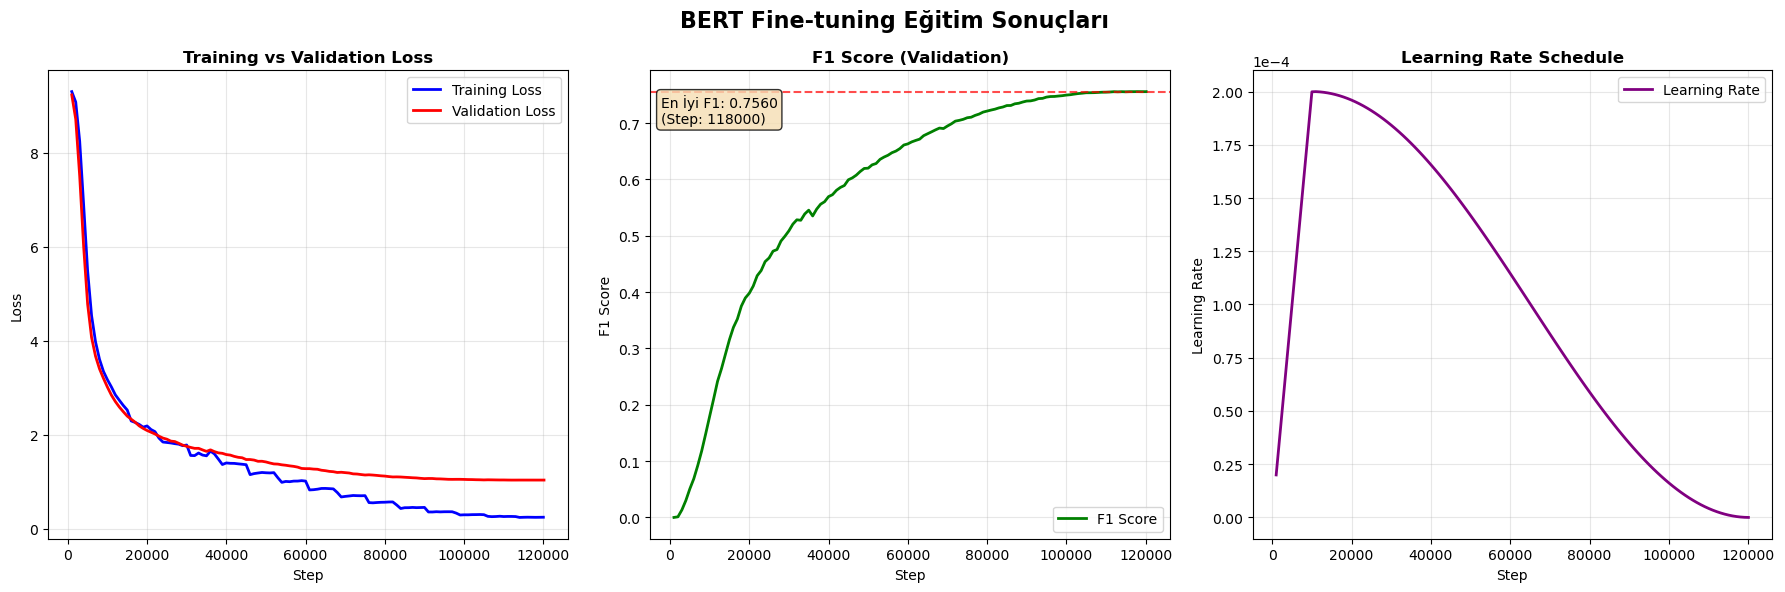


📊 BASELINE MODEL EĞİTİM ÖZETİ
🔢 Dataset: (10390 sınıf)
🔹 Son Training Loss: 0.2432
🔹 Son Validation Loss: 1.0337
🔹 En İyi F1 Score: 0.7560
🔹 Son F1 Score: 0.7560
🔹 Başlangıç Learning Rate: 2.00e-05
🔹 Son Learning Rate: 1.76e-09
🔹 LR Azalma Oranı: 0.0%


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Anaconda\envs\Pytorch\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Anaconda\envs\Pytorch\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] Varolan bir bağlantı uzaktaki bir ana bilgisayar tarafından zorla kapatıldı
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Anaconda\envs\Pytorch\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Anaconda\envs\Pytorch\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] Varolan bir bağlantı uzaktaki 

In [6]:
print("\n--- MODEL EĞİTİM GRAFİKLERİ ÇİZİLİYOR ---")

import matplotlib.pyplot as plt
import pandas as pd

try:
    # Training history'den verileri çek
    history = trainer.state.log_history
    
    # Training ve validation verilerini ayır
    train_logs = [log for log in history if 'loss' in log and 'eval_loss' not in log]
    eval_logs = [log for log in history if 'eval_loss' in log]
    
    # Data Frame oluştur
    train_df = pd.DataFrame(train_logs)
    eval_df = pd.DataFrame(eval_logs)
    
    # 2x2 subplot oluştur
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('BERT Fine-tuning Eğitim Sonuçları', fontsize=16, fontweight='bold')
    
    # 1. Training vs Validation Loss (Aynı grafikte)
    if not train_df.empty and 'loss' in train_df.columns:
        ax1.plot(train_df['step'], train_df['loss'], 'b-', linewidth=2, label='Training Loss')
    if not eval_df.empty and 'eval_loss' in eval_df.columns:
        ax1.plot(eval_df['step'], eval_df['eval_loss'], 'r-', linewidth=2, label='Validation Loss')
    
    ax1.set_title('Training vs Validation Loss', fontweight='bold')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 2. F1 Score
    if not eval_df.empty and 'eval_f1' in eval_df.columns:
        ax2.plot(eval_df['step'], eval_df['eval_f1'], 'g-', linewidth=2, label='F1 Score')
        ax2.set_title('F1 Score (Validation)', fontweight='bold')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('F1 Score')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # En iyi F1 score'u göster
        best_f1 = eval_df['eval_f1'].max()
        best_step = eval_df.loc[eval_df['eval_f1'].idxmax(), 'step']
        ax2.axhline(y=best_f1, color='red', linestyle='--', alpha=0.7)
        ax2.text(0.02, 0.95, f'En İyi F1: {best_f1:.4f}\n(Step: {best_step})', 
                transform=ax2.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 3. Learning Rate
    if not train_df.empty and 'learning_rate' in train_df.columns:
        ax3.plot(train_df['step'], train_df['learning_rate'], 'purple', linewidth=2, label='Learning Rate')
        ax3.set_title('Learning Rate Schedule', fontweight='bold')
        ax3.set_xlabel('Step')
        ax3.set_ylabel('Learning Rate')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
        ax3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    plt.tight_layout()
    plt.savefig('imbalance_baseline_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Özet istatistikler yazdır
    print("\n" + "="*60)
    print("📊 BASELINE MODEL EĞİTİM ÖZETİ")
    print("="*60)
    
    print(f"🔢 Dataset: ({num_labels} sınıf)")
    
    if not train_df.empty:
        final_train_loss = train_df['loss'].iloc[-1]
        print(f"🔹 Son Training Loss: {final_train_loss:.4f}")
    
    if not eval_df.empty:
        final_val_loss = eval_df['eval_loss'].iloc[-1]
        best_f1 = eval_df['eval_f1'].max()
        final_f1 = eval_df['eval_f1'].iloc[-1]
        print(f"🔹 Son Validation Loss: {final_val_loss:.4f}")
        print(f"🔹 En İyi F1 Score: {best_f1:.4f}")
        print(f"🔹 Son F1 Score: {final_f1:.4f}")
    
    if not train_df.empty and 'learning_rate' in train_df.columns:
        final_lr = train_df['learning_rate'].iloc[-1]
        initial_lr = train_df['learning_rate'].iloc[0]
        print(f"🔹 Başlangıç Learning Rate: {initial_lr:.2e}")
        print(f"🔹 Son Learning Rate: {final_lr:.2e}")
        print(f"🔹 LR Azalma Oranı: {(final_lr/initial_lr)*100:.3f}%")
    
except Exception as e:
    print(f"❌ Grafik oluşturma hatası: {e}")
    print("⚠️ Training history verilerine erişilemedi.")